## 📒 Model Deteksi Covid-19 melalui Gambar Dada X-ray Pasien menggunakan CNN **MobileNetV2**

> Pada model ini, digunakan hanya arsitektur dari **MobileNetV2** - berdasarkan dari model terbaik yang telah diuji dalam jurnal tersebut.

> Dalam prosesnya, pelatihan model ini menggunakan beberapa langkah, yakni:

### 📦 **1. Import Libraries**

> Untuk proses pertama, kita memerlukan untuk mengimpor dari beberapa library yang akan dibutuhkan untuk proses selanjutnya

- Pertama kita memerlukan untuk mengimpor `os` agar dapat dengan mudah untuk manipulasi direktori file yang diperlukan, contohnya melalui direktori data kita `dataset/` dan `dataset_test/` -> kita memerlukan `os` untuk mengambil data yang ada dalam file tersebut.

- Kedua kita memerlukan mengimpor `matplotlib` bagian `image` agar kita dapat membaca dan menampilkan gambar yang diperlukan, serta `pyplot` agar kita dapat membuat grafik akurasi dan loss dari training.

- Ketiga kita memerlukan mengimpor `random` untuk melakukan operasi acak yang diinginkan, contoh dalam kasus ini adalah operasi acak untuk memilih satu gambar dalam masing - masinga kelas **covid** dan kelas **normal**.

- Keempat kita memerlukan mengambil *tensorflow* (**Hal terpenting**) bagian:  

  - ***keras.preprocessing.image*** untuk mengimpor `ImageDataGenerator` agar dapat memproses gambar yang telah diambil melalui `os` dan dibaca oleh `matplotlib.image` dengan cara normalisasi (*rescale*) dan augmentasi data (*zoom*, *rotate*, dll).

  - ***keras.model*** untuk mengimpor `Model` agar dapat mengedit dan membuat kustom sendiri dari model dasar yang dipakai (**MobileNetV2**) -> dalam kasus ini kita memakainya untuk menambahkan layer sendiri ke model pretrained sebelumnya.

  - ***keras.layer*** untuk mengimpor `Dense` (agar dapat menambahkan layer yang fully connected), `Dropout` (agar dapat menghindari overfitting dari neuron dengan cara menghapus secara acak dari neuron saat training), dan `GlobalAveragePooling2D` (untuk mengganti flatten dari **MobileNetV2** sebelum masuk `Dense`-> agar tidak terjadi overfitting karena terlalu panjang vektor yang dihasilkan dari output shape CNN nya ).

  - ***keras.application*** untuk mengimpor model `MobileNetV2` yang telah pretrained dari ImageNet.

  - ***keras.optimizers*** untuk mengimpor `Adam` atau **Adaptive Moment Estimation** (hal ini digunakan untuk meng-update bobot setelah menghitung loss dari perubahan akurasi di setiap epoch / iterasi).

- Kelima kita memerlukan mengambil *sklearn* untuk mengimpor `classification_report` (digunakan untuk menghitung dan menampilkan precision, recall, dan f1-score) dan `confusion_matrix` (digunakan untuk membuat **confusion matrix** yang akan dipakai sebagai prediksi benar/salah per-kelas).

- Keenam kita memerlukan mengimpor `seaborn` untuk mengubah *visualisasi data statistik* yang akan dipakai di pembuatan **confusion matriks** agar lebih berbeda -> dalam kasus ini untuk mengubah warnanya agar terlihat lebih kontras yang lebih banyak dan nihil yang lebih sedikit.

In [1]:
# ============================================
# 1. Import Libraries
# ============================================
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

### 🖼️ **2. Menampilkan Gambar Sebelum Preprocessing**

> Untuk proses kedua, kita perlu untuk menampilkan contoh gambar dari masing-masing kelas (NORMAL & COVID) sebelum dilakukannya preprocessing. 

- Pertama, kita memerlukan untuk mencari path untuk dataset yang mau kita tampilkan `dataset`-> selanjutnya kita juga perlu data kelas yang ada dalam `dataset` tersebut.

- Kedua, kita memerlukan untuk mengambil sampel random dari setiap kelas, disini kita menggunakan `os` untuk menggabungkan path folder `dataset` tersebut dengan nama kelas nya -> selanjutnya `os` digunakan kembali untuk mengambil seluruh list file gambar dari kedua kelas tersebut -> kemudian `random` digunakan untuk mengambil acak satu gambar dari setiap kelas untuk dijadikan sampel gambar -> dan terakhir melalui dictionary kosong `sampels` tadi, kita simpan data sampel gambar dari setiap kelas.


- Selanjutnya kita memerlukan untuk membuat dari tampilan gambarnya tersebut -> pertama dengan `pyplot` kita dapat mengatur dari ukuran canvas (`figsize`), subplot-nya, tampilan gambarnya (memakai *gray* karena berbentuk grayscale), dan title canvasnya (`title`). pembentukan ini di lakukan loop agar dapat menampilkan gambar berdasarkan `class_names` sebelumnya.

> Hasilnya akan menampilkan sampel gambar dari kiri ke kanan yaitu ***Covid-19*** dan ***Normal*** dengan isi dictionary kosong `sampels` tadi yakni **{'COVID - Original': 'dataset/COVID/ x.png', 'NORMAL - Original': 'dataset/NORMAL/ y.png'}**

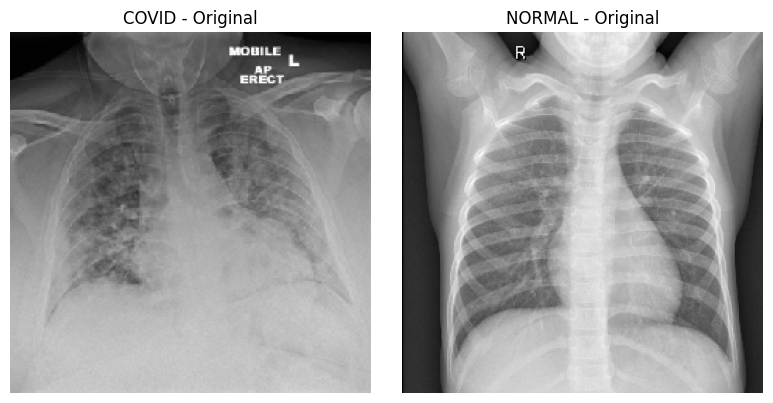

In [2]:
# ============================================
# 2. Menampilkan Gambar sebelum di preprocessing
# ============================================

base_dir = 'dataset/'  
class_names = ['COVID', 'NORMAL']  
samples = {}

for cls in class_names:
    class_path = os.path.join(base_dir, cls)
    img_list = os.listdir(class_path)
    sample_img = random.choice(img_list)
    samples[cls] = os.path.join(class_path, sample_img)

# Tampilkan gambar asli
plt.figure(figsize=(8, 4))
for i, cls in enumerate(class_names):
    img = mpimg.imread(samples[cls])
    plt.subplot(1, 2, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"{cls} - Original")
    plt.axis('off')
plt.tight_layout()
plt.show()

### ⚙️ **3. Data Preprocessing & Augmentasi**

> Untuk proses ketiga, kita telah siap untuk melakukan pemrosesan data beserta Augmentasinya

- Pertama, kita perlu membagi isi `dataset` awal yang berisi kedua kelas tersebut ke dalam tiga direktori yang diantaranya adalah **direktori training**, **direktori validasi**, dan **direktori testing**. Pembagiannya yaitu dalam **direktori training** akan berisi 70% data gambar dari masing - masing kelas, **direktori validasi** akan berisi 15% data gambar dari masing - masing kelas, dan **direktori testing** akan berisi 15% data gambar dari masing - masing kelas.

- Kedua, setelah kita mengatur dan membagi isi `dataset` tersebut. Kita dapat melakukan *preprocessing* dengan menggunakan `ImageDataGenerator` sebelumnya untuk dapat memproses data gambar di **direktori training** seperti menormalisasikan *pixel* gambar (`rescale`) dari 0-255 -> 0-1, dan Augmentasi data dengan memutar gambar sebanyak 15 derajat (`rotate`) dan membesarkan bagian tertentu pada gambar secara acak hingga 10% untuk variasi bentuk (`zoom`).

- Ketiga, setelah kita memproses **direktori training**. Kita perlu memproses data validasi dan testing, namun karena data ini hanya digunakan sebagai evaluasi akhir, maka gambar hanya perlu dinormalisasikan (`rescale`) *pixel* gambar nya dari 0-255 -> 0-1 saja.

- Keempat, setelah semua data direktori diproses, maka selanjutnya kita membuat **data generator** pada setiap direktori sebelumnya. Pertama kita memerlukan metode `flow_from_directory` dari `ImageDataGenerator` sebelumnya, yang dimana didalamnya akan diambil data dari **direktori training** dahulu -> kemudian dilakukan resize ukuran gambar menjadi 244 x 244 -> lalu mengambil batch per 15 gambar -> terakhir mengklasifikasikan `class_mode` nya menjadi binary karena hanya menggunakan dua kelas saja. (Sisanya sama untuk direktori validasi dan testing, namun untuk testing tidak dilakukan pengacakan untuk evaluasi dan matching label saat ***confusion matriks***).

In [3]:
# ============================================
# 3. Data Preprocessing dan Augmentasi
# ============================================
train_path = 'dataset_test/train'
val_path = 'dataset_test/val'
test_path = 'dataset_test/test'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(244, 244),
    batch_size=15,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(244, 244),
    batch_size=15,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(244, 244),
    batch_size=15,
    class_mode='binary',
    shuffle=False
)

Found 2400 images belonging to 2 classes.
Found 514 images belonging to 2 classes.
Found 514 images belonging to 2 classes.


### 🔄 **4. Transfer Learning - MobileNetV2**

> Untuk proses keempat, setelah kita telah memproses data gambar yang ada di dalam ketiga direktori tersebut, selanjutnya kita akan melakukan **Transfer Learning** - Via `MobileNetV2`, yaitu model CNN dengan arsitektur ResNet50V2 dari ImageNet dan ditambahkan layer custom untuk klasifikasi biner kelas *COVID* dengan *NORMAL*.

- Pertama, kita memerlukan untuk mengambil model yang telah di pretrained, dari `MobileNetV2` tersebut dengan bobotnya dari dataset `ImageNet` yang dimana mencakup 1.2 juta gambar per 1000 kelas, tidak memakai `dense` bawaan agar bisa di kustom nantinya, dan ukuran input gambarnya 244 x 244 RGB

- Kedua, model tersebut perlu dibekukan agar bobot yang telah kita ambil tersebut tidak dilatih ulang.

- Ketiga, bagian kustom nya ini -> kita mengkustom bagian pengambilan output dari *feature map* terakhir yang dimana tanpa `flatten`, lalu kita mengganti *feature map* terakhir itu dari `flatten` menjadi GAP (`GlobalAveragePooling2D`), kemudian mematikan neuron sebanyak 50% saat training nanti menggunakan `Dropout`, dan terakhir mengaktifkan fully connected layer (`dense`) dengan aktivasinya dari `sigmod`, agar hasil layer output biner probabilitasnya 0-1 yang cocok buat dua kelas aja.

- Keempat, setelah dikustomisasi kita memerlukan untuk membangun dan mengkompilasi dari model tersebut, membangun modelnya memakai `Model` dari keras dan mengkompilenya menggunakan optimisasi `Adam` **Adaptive Moment Estimation** dengan `learning_rate` nya kisaran 1e-3 (Yang dimana langkah update bobot dari optimizer kisaran 0.001) serta mengevaluasi performa saat training dalma metriks

In [4]:
# ============================================
# 4. Transfer Learning - MobileNetV2
# ============================================
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(244, 244, 3))
base_model.trainable = False  

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

C:\Users\Ditto\AppData\Local\Temp\ipykernel_18576\2425714083.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(244, 244, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 16s 2us/step


### 🧠 **5. Training Model**

> Untuk proses kelima, setelah sebelumnya kita memodifikasi dari bagian model nya, sekarang kita bisa untuk melakukan training data menggunakan model tersebut.

- Pertama, kita memerlukan mengambil model dari `train_generator` sebelumnya dengan perulangan sebanyak 100 kali (`epoch`), setelahnya data validasi digunakan untuk mengevaluasi model disetiap `epoch` tersebut. Di `history` ini juga disimpan obyek metrik selama training seperti akurasi dan loss setiap `epoch` dan dilakukan iterasi.

- Kedua, setelah hasil training selesai dan keluar. Maka kita perlu untuk memvisualisasikan dari hasil akurasi dan loss tersebut, kembali menggunakan `history` untuk mengambil data akurasi-loss nya dan validasi-loss nya.

- Ketiga, kita memerlukan untuk menampilkan hasilnya dalam bentuk grafik dalam canvas, digunakan kembali `pyplot` untuk membuat grafik berdasarkan `epoch_range` dari *akurasi dan validasi* serta dari *loss akurasi dan loss validasi*

c:\Lang\Python\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 83s 500ms/step - accuracy: 0.8264 - loss: 0.3817 - val_accuracy: 0.9611 - val_loss: 0.1023
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 84s 523ms/step - accuracy: 0.9705 - loss: 0.0891 - val_accuracy: 0.9708 - val_loss: 0.0845
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 87s 545ms/step - accuracy: 0.9683 - loss: 0.0788 - val_accuracy: 0.9708 - val_loss: 0.0759
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 95s 593ms/step - accuracy: 0.9821 - loss: 0.0513 - val_accuracy: 0.9728 - val_loss: 0.0791
Epoch 5/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 90s 562ms/step - accuracy: 0.9780 - loss: 0.0619 - val_accuracy: 0.9786 - val_loss: 0.0626
Epoch 6/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 90s 565ms/step - accuracy: 0.9878 - loss: 0.0397 - val_accuracy: 0.9805 - val_loss: 0.0566
Epoch 7/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 70s 439ms/step - accuracy: 0.9801 - loss: 0.0551 - val_accuracy: 0.9767 - val_loss: 0.0550
Epoch 8/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 60s 377ms/step - accuracy: 0.9900 - loss: 0

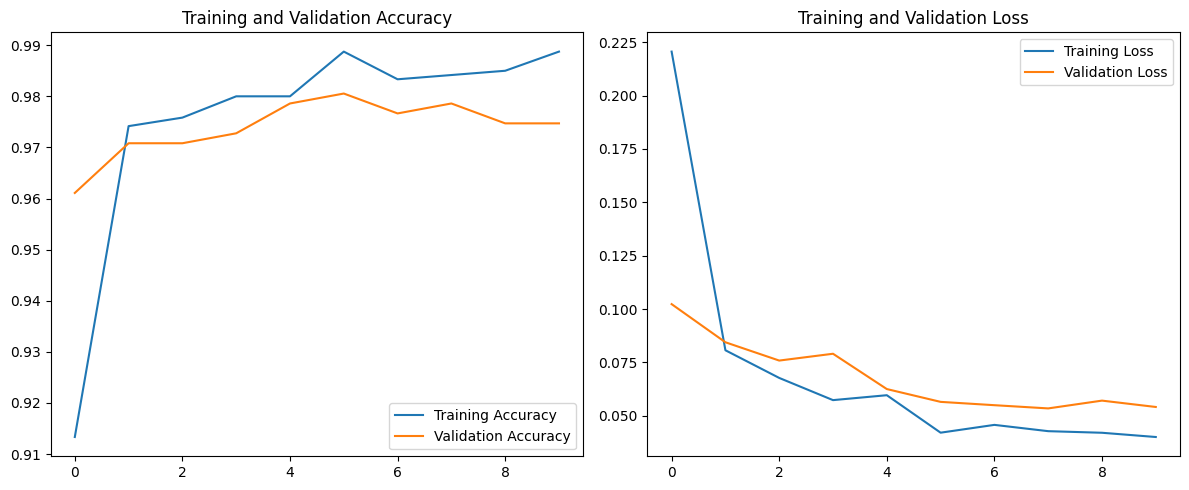

In [5]:
# ============================================
# 5. Training
# ============================================

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
)

# ============================================
# 5.1 Visualisasi Akurasi dan Loss
# ============================================
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()


### 🔍 **6. Visualisasi Gambar Setelah Preprocessing**

> Setelah dilakukan iterasi untuk melihat hasil *akurasi-loss* dan *validasi-loss*, maka kita akan memperlihatkan gambar setelah preprocessing

- Pertama, kita memerlukan untuk mengambil salah satu batch dari `train_generator` berdasarkan label dan ukuran gambar yang kemudian akan ditampilkan menggunakan `pyplot` dalam canvas. Prosesnya simpel yaitu ngukur canvas sampai ukuran 12 x 6, lalu nampilin 6 gambar pertama dari batch, lalu buat `layout` dari `subplot` sebesar 2 baris x 3 kolom, kemudian menampilkan gambar tersebut, dan terakhir mengatur `title` dan mengatur `layout` agar rapi.



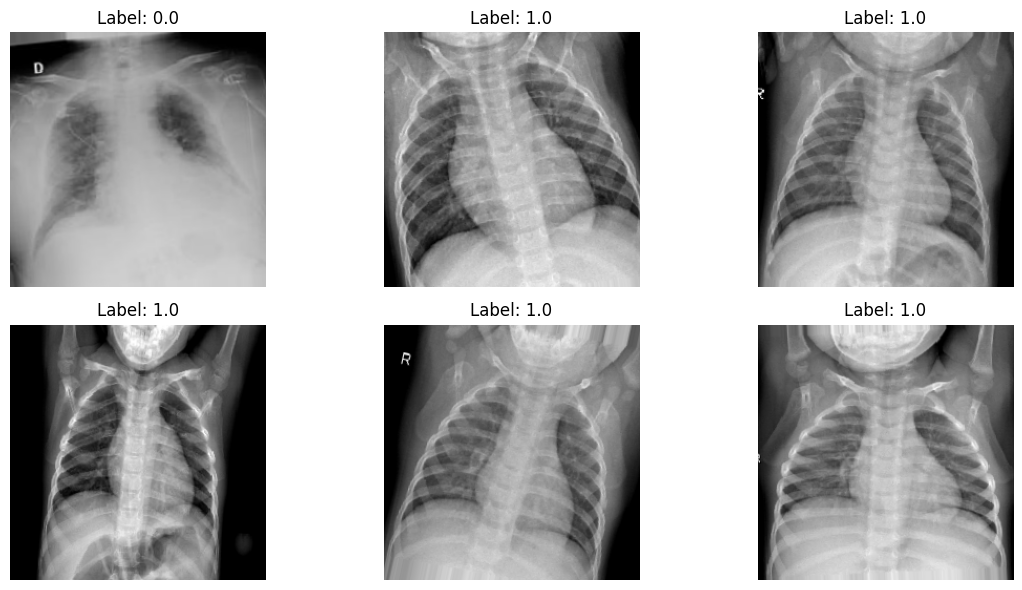

In [6]:

# ============================================
# 6. Tampilkan gambar setelah preprocessing
# ============================================

# Ambil satu batch dari train_generator
images, labels = next(train_generator)

# Tampilkan beberapa gambar hasil preprocessing
plt.figure(figsize=(12, 6))
for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(images[i])
    if labels[i].ndim > 0:
        plt.title(f"Label: {labels[i].argmax()}")
    else:
        plt.title(f"Label: {labels[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

### 🧩 **7. Evaluasi Model (Confusion Matrix)**

#### Proses terakhir ini untuk mengevaluasi model tersebut menggunakan data dari **direktori testing** 

- Pertama, kita perlu mengambil data gambar dari **direktori testing** sebelumnya

- Kedua, setelah diambil dilakukan prediksi yang menghasilkan nilai probabilitas antara 0.0 - 1.0, kemudian dilakukan prediksi ke label akhir yang dimana jika > 0.5 → 1 termasuk NORMAL, tapi jika ≤ 0.5 → 0 termasuk COVID

- Ketiga, menampilkan hasil dari metrik klasifikasi precision, recall, f1-score melalui data gambar **direktori testing**.

- Keempat, setelah jadi semua - kita tinggal memerlukan untuk menampilkan nya menjadi gambar dalam canvas yang menggunakan heatmap sebagai penanda banyak sedikitnya angka disetiap kotak. Digunakan kembali `pyplot` dalam hal ini untuk mengukur ukuran canvas (6 x 4), kemudian `title` hingga label x dan y. `seaborn` digunakan disini untuk memberi warna heatmap pada kotak tersebut berdasarkan angkanya.

### 📊 **Hasil akhir: Confusion matriks dengan isi sebagai berikut:**

> **True Positive** sebanyak 270 -> berarti pasien tersebut `normal` dan telah diklasifikasikan dengan `benar`

> **True Negative** sebanyak 235 -> berarti pasien tersebut terkena `covid-19` dan telah diklasifikasikan dengan `benar`

> **False Positive** sebanyak 9 -> berarti pasien yang termasuk terkena `covid-19` salah diklasifikasikan sebagai `normal`

> **False Negative** sebanyak 0 -> berarti pasien yang termasuk `normal` tidak ada yang salah diklasifikasikan  sebagai `covid-19`
    

### 🧪 **Penjelasannya:**

>  Dari akurasi dapat dihitung dengan rumus `( TP + TN ) / Total = (270 + 235) / 514 ≈ 0.9824 → 98.24%`, Menjadikan akurasi ini sangat tinggi dengan kecil kesalahan.

> Dari presisinya dapat dihitung dengan rumus `TP / (TP + FP) = 270 / (270 + 9) ≈ 0.967`, menjadikan presisi model ini sangat tinggi.

> Dari recall kelas normal dapat dihitung sebagai berikut `TP / (TP + FN) = 270 / (270 + 0) = 1.0`, menjadikan semua orang berhasil dikenali dengan sempurna.

> Dari f1-score dapat dihitung sebagai berikut `2 * (Precision * Recall) / (Precision + Recall) ≈ 2 * (0.967 * 1.0) / (0.967 + 1.0) ≈ 0.983`,   ***menjadikan model ini sebagai model stabil dan terbaik yang layak dipakai untuk deteksi pasien covid-19 dengan minim kesalahan***. 

35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 275ms/step
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       244
           1       0.97      1.00      0.98       270

    accuracy                           0.98       514
   macro avg       0.98      0.98      0.98       514
weighted avg       0.98      0.98      0.98       514



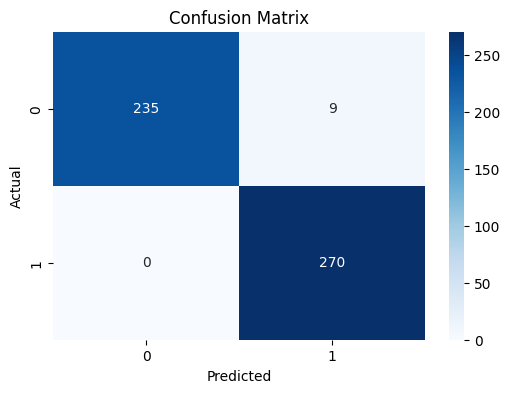

In [7]:
# ============================================
# 7. Tampilkan hasil evaluasi model melalui confusion matriks
# ============================================
Y_pred = model.predict(test_generator)
y_pred = (Y_pred > 0.5).astype(int)

print(classification_report(test_generator.classes, y_pred))
cm = confusion_matrix(test_generator.classes, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()